In [1]:
#IMPORTS
import firebase_admin
from firebase_admin import firestore
from firebase_admin import credentials
import pandas as pd

In [2]:
cred = credentials.Certificate("./brazillian-gastronomic-tour-firebase-adminsdk-ojrgu-1c98d6e4b6.json")
app = firebase_admin.initialize_app(cred)

db = firestore.client()

In [83]:
def collection_to_df(collection):
    items = list(db.collection(collection).stream())
    items_dict = list(map(lambda x: {'id': x.id, **x.to_dict()}, items))
    return pd.DataFrame(items_dict)
    

# Inicializando dataframes

In [84]:
#Initialize Dataframes

users_df = collection_to_df("users")
users_df = users_df.rename(columns={"gameLevel": "currentGameLevel"})
users_df = users_df.rename(columns={"id": "user"})
users_df = users_df.set_index("user")

# REMOVE Gilberto e Caio
users_df = users_df.drop(index = "GyaYyj1DPDQCFL8dtFJeLUbnqsr2").drop(index = "LrXx1XUUAfT05eBhi37WwrUF33e2")


user_level_df = collection_to_df("userLevel")

a_questions_df = collection_to_df("answeredQuestions")
a_questions_df['question'] = a_questions_df['question'].astype(int)
a_questions_df = a_questions_df.drop(columns=["correctAnswer", "id"])
questions_df = collection_to_df("questions")
questions_df = questions_df.rename(columns={"id": "question"})
questions_df['question'] = questions_df['question'].astype(int)

a_questions_df['lastUpdated']  = pd.to_datetime(a_questions_df.lastUpdated)
a_questions_df = questions_df.merge(a_questions_df, how="inner", on="question")
a_questions_df = a_questions_df.merge(users_df, how="inner", on="user")

a_questions_df = a_questions_df.sort_values("lastUpdated", ascending=True)

user_level_df = user_level_df.merge(users_df, how="inner", on="user")

#users_df


# Notas
### Relação de notas dos jogadores por fase prática e de domínio

In [85]:

#user_nota

user_nota = a_questions_df.query("attemptNumber == 1").groupby(["user", "lagunasPhase", "ageRange", "gender", "correct"], as_index=False)["question"].count()

user_nota = user_nota.pivot_table(index=["user","ageRange", "gender", "lagunasPhase"], 
                    columns=["correct"], 
                    values='question',
                    fill_value=0, 
                    aggfunc='sum').reset_index()


# 4 = coluna True
# 3 = coluna False



user_nota["nota"] = (user_nota.iloc[:,5] / (user_nota.iloc[:,5] + user_nota.iloc[:,4])) * 10


user_nota.head(2)


correct,user,ageRange,gender,lagunasPhase,False,True,nota
0,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,46-55,Male,domain,1,26,9.629630
1,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,46-55,Male,practice,8,20,7.142857


### Relação de notas dos jogadores por fase prática e de domínio e level

In [86]:
#user_nota_level

user_nota_level = a_questions_df.query("attemptNumber == 1").groupby(["user", "level", "lagunasPhase", "ageRange", "gender", "correct"], as_index=False)["question"].count()

user_nota_level = user_nota_level.pivot_table(index=["user", "ageRange", "gender", "level", "lagunasPhase"], 
                    columns=["correct"], 
                    values='question',
                    fill_value=0, 
                    aggfunc='sum').reset_index()

user_nota_level["nota"] = (user_nota_level.iloc[:,6] / (user_nota_level.iloc[:,6] + user_nota_level.iloc[:,5])) * 10

user_nota_level.head(6)

#user_nota_level.query("user =='c6yyrnc6SAVNAgeTUVNVdXACrBo2'")

correct,user,ageRange,gender,level,lagunasPhase,False,True,nota
0,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,46-55,Male,1,domain,1,9,9.00
1,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,46-55,Male,1,practice,2,8,8.00
2,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,46-55,Male,2,domain,0,10,10.00
3,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,46-55,Male,2,practice,3,7,7.00
4,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,46-55,Male,3,domain,0,7,10.00
5,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,46-55,Male,3,practice,3,5,6.25


# Relação de acerto e erro

### Acerto e erro por nível

In [87]:
#acerto_erro_by_nivel

acerto_erro_by_nivel = a_questions_df.query("attemptNumber == 1").groupby(["level", "correct"], as_index=False).agg({'question': 'count'})

acerto_erro_by_nivel['percent'] =  acerto_erro_by_nivel['question'] / acerto_erro_by_nivel.groupby(['level'])['question'].transform('sum') * 100
acerto_erro_by_nivel

,level,correct,question,percent
0,1,False,65,23.131673
1,1,True,216,76.868327
2,2,False,36,16.363636
3,2,True,184,83.636364
4,3,False,25,19.531250
5,3,True,103,80.468750


### Acerto e erro por fase prática e de domínio

In [88]:
#acerto_erro_by_phase

acerto_erro_by_phase = a_questions_df.query("attemptNumber == 1").groupby(["lagunasPhase", "correct"], as_index=False).agg({'question': 'count'})


acerto_erro_by_phase['percent'] =  acerto_erro_by_phase['question'] / acerto_erro_by_phase.groupby(['lagunasPhase'])['question'].transform('sum') * 100
acerto_erro_by_phase

,lagunasPhase,correct,question,percent
0,domain,False,20,6.369427
1,domain,True,294,93.630573
2,practice,False,106,33.650794
3,practice,True,209,66.349206


### Acerto e erro por fase e nível

In [89]:
#Taxa de acerto e erro por nível e mostrando a fase laguna

acerto_erro_by_phase_level = a_questions_df.query("attemptNumber == 1").groupby(["level", "lagunasPhase", "correct"], as_index=False).agg({'question': 'count'})


acerto_erro_by_phase_level['percent'] =  acerto_erro_by_phase_level['question'] / acerto_erro_by_phase_level.groupby(['level'])['question'].transform('sum') * 100
acerto_erro_by_phase_level

,level,lagunasPhase,correct,question,percent
0,1,domain,False,15,5.338078
1,1,domain,True,125,44.483986
2,1,practice,False,50,17.793594
3,1,practice,True,91,32.384342
4,2,domain,False,3,1.363636
5,2,domain,True,107,48.636364
6,2,practice,False,33,15.000000
7,2,practice,True,77,35.000000
8,3,domain,False,2,1.562500
9,3,domain,True,62,48.437500


### Acerto e erro por faixa etária

In [90]:
acerto_erro_by_age_range = a_questions_df.query("attemptNumber == 1").groupby(["ageRange", "correct"], as_index=False).agg({'question': 'count'})
acerto_erro_by_age_range


,ageRange,correct,question
0,1-18,False,30
1,1-18,True,133
2,18-25,False,71
3,18-25,True,246
4,26-35,False,16
5,26-35,True,78
6,46-55,False,9
7,46-55,True,46


### Acerto e erro por gênero

In [91]:
acerto_erro_by_gender = a_questions_df.query("attemptNumber == 1").groupby(["gender", "correct"], as_index=False).agg({'question': 'count'})
acerto_erro_by_gender

,gender,correct,question
0,Female,False,73
1,Female,True,238
2,Male,False,53
3,Male,True,265


# Porcentagem de acerto e erro por questão

In [92]:
#questions_percentage

questions_percentage = a_questions_df.query("attemptNumber == 1").groupby(["question", "correct"], as_index=False)["text"].count().rename(columns={"text": "count"})


questions_percentage = questions_percentage.pivot_table(index=["question"], 
                    columns=["correct"], 
                    values='count',
                    fill_value=0, 
                    aggfunc='sum').reset_index()

questions_percentage.rename(columns={ questions_percentage.columns[2]: "corretas" }, inplace = True)
questions_percentage.rename(columns={ questions_percentage.columns[1]: "erradas" }, inplace = True)


questions_percentage["% corretas"] = (questions_percentage["corretas"] * 100 / (questions_percentage["corretas"] + questions_percentage["erradas"]))
questions_percentage["% erradas"] = (questions_percentage["erradas"] * 100 / (questions_percentage["corretas"] + questions_percentage["erradas"]))
questions_percentage["total de perguntas"] = questions_percentage["erradas"]  + questions_percentage["corretas"] 

questions_percentage.head(3)

correct,question,erradas,corretas,% corretas,% erradas,total de perguntas
0,2,4,24,85.714286,14.285714,28
1,3,8,20,71.428571,28.571429,28
2,4,2,26,92.857143,7.142857,28


# Classificação de perfis de acordo com a metodologia Serrano-Laguna

In [93]:
#Definição de perfis laguna
#IT = 6
#FT = 8


it = 7
ft = 8
# FA >= FT ==> 
def classifier(row):
    if row["domain"] >= ft:
            if row["practice"] < it:
                  return "learner"
            else:
                  return "master"
    else:
            if row["practice"] < it:
                  return "non-learner"
            else:
                  return "outlier"

user_nota_classification = user_nota.pivot(index=["user", "ageRange"], columns=["lagunasPhase"], values="nota")
user_nota_classification["classification"] = user_nota_classification.apply(classifier, axis=1)

user_nota_classification.head(3)


,lagunasPhase,domain,practice,classification
user,ageRange,,,
1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,46-55,9.629630,7.142857,master
2oh7qd25jNSrFcLrxGlVtAl5hvk1,18-25,6.666667,5.185185,non-learner
BJPHmgFSwpMSOkUVslu46yXK68U2,18-25,10.000000,7.407407,master


### Gráfico com a clasificação geral

<Axes: ylabel='count'>

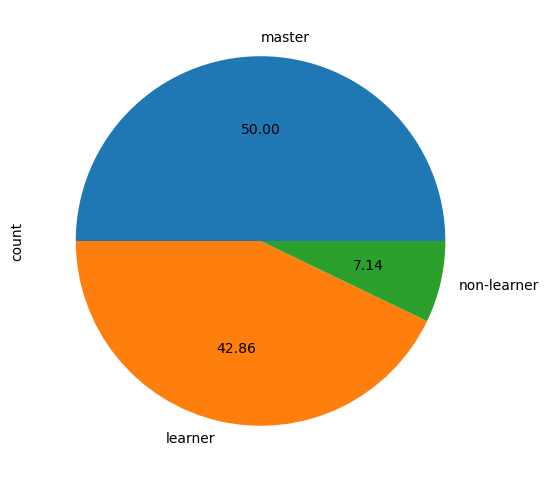

In [94]:
#Plot Grafico
user_nota_classification["classification"].value_counts().plot.pie(figsize=(6, 6), autopct="%.2f")

In [95]:
#user_nota_classification_level

user_nota_classification_level = user_nota_level.pivot(index=["user", "level"], columns="lagunasPhase", values="nota").reset_index()
user_nota_classification_level["classification"] =  user_nota_classification_level.apply(classifier, axis=1)
user_nota_classification_level.head(9)

lagunasPhase,user,level,domain,practice,classification
0,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,1,9.000000,8.000000,master
1,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,2,10.000000,7.000000,master
2,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,3,10.000000,6.250000,learner
3,2oh7qd25jNSrFcLrxGlVtAl5hvk1,1,4.000000,3.000000,non-learner
4,2oh7qd25jNSrFcLrxGlVtAl5hvk1,2,8.000000,7.000000,master
5,2oh7qd25jNSrFcLrxGlVtAl5hvk1,3,8.571429,5.714286,learner
6,BJPHmgFSwpMSOkUVslu46yXK68U2,1,10.000000,6.000000,learner
7,BJPHmgFSwpMSOkUVslu46yXK68U2,2,10.000000,8.000000,master
8,BJPHmgFSwpMSOkUVslu46yXK68U2,3,10.000000,8.571429,master


### Gráfico com a clasificação por nível

In [96]:
#user_nota_classification_level_reshaped

user_nota_classification_level_reshaped = user_nota_classification_level.drop(["domain", "practice"], axis=1)

user_nota_classification_level_reshaped = user_nota_classification_level_reshaped.groupby(["level", "classification"]).count().reset_index()

user_nota_classification_level_reshaped = pd.pivot_table(user_nota_classification_level_reshaped, index = "classification", columns="level", values="user", fill_value=0)

user_nota_classification_level_reshaped



level,1,2,3
classification,,,
learner,7,3,5
master,6,8,4
non-learner,1,0,0


array([<Axes: ylabel='1'>, <Axes: ylabel='2'>, <Axes: ylabel='3'>],
      dtype=object)

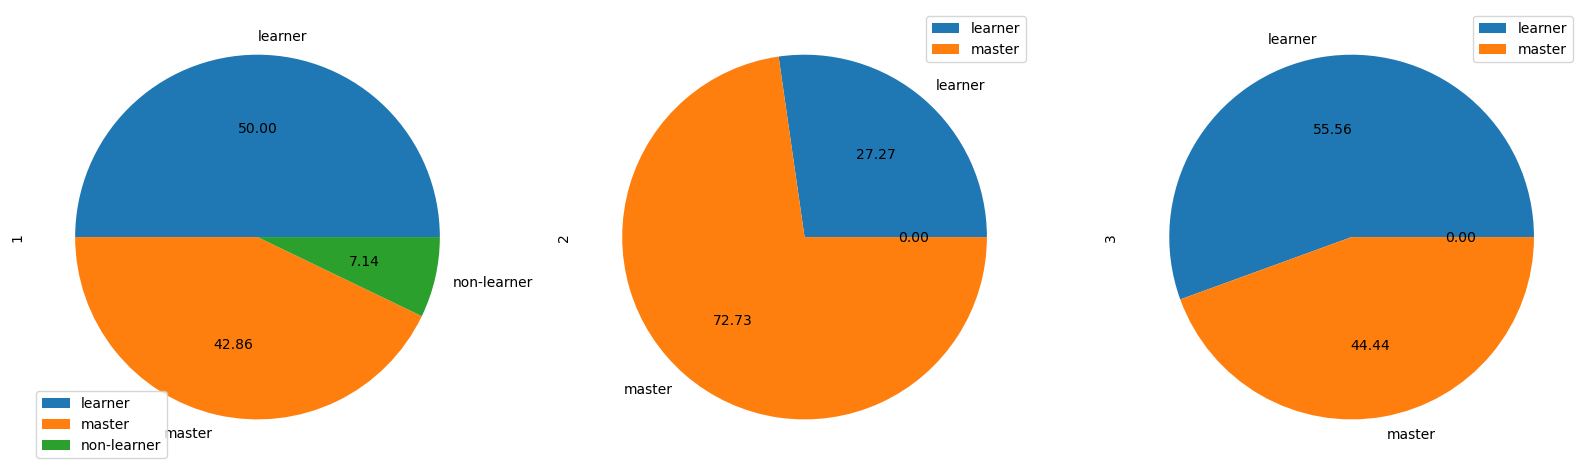

In [97]:
#Plot Grafico

user_nota_classification_level_reshaped.plot.pie(subplots=True,figsize=(20, 10), autopct="%.2f")

### Gráfico com a classificação por faixa etária

In [98]:
user_nota_classification_age_range = user_nota.pivot(index=["user",  "ageRange"], columns=["lagunasPhase"], values="nota").reset_index()
user_nota_classification_age_range["classification"] =  user_nota_classification_age_range.apply(classifier, axis=1)
user_nota_classification_age_range = user_nota_classification_age_range.drop(["domain", "practice"], axis=1)
user_nota_classification_age_range = user_nota_classification_age_range.groupby(["ageRange", "classification"]).count().reset_index()

user_nota_classification_age_range = pd.pivot_table(user_nota_classification_age_range, index = "classification", columns="ageRange", values="user", fill_value=0)
user_nota_classification_age_range

ageRange,1-18,18-25,26-35,46-55
classification,,,,
learner,2,4,0,0
master,1,3,2,1
non-learner,0,1,0,0


array([<Axes: title={'center': '1-18'}, xlabel='classification'>,
       <Axes: title={'center': '18-25'}, xlabel='classification'>,
       <Axes: title={'center': '26-35'}, xlabel='classification'>,
       <Axes: title={'center': '46-55'}, xlabel='classification'>],
      dtype=object)

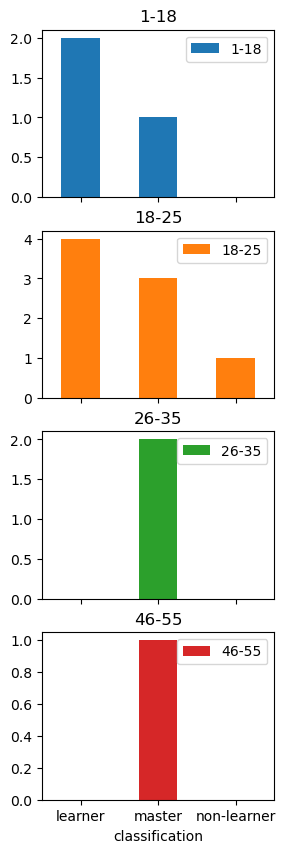

In [99]:
user_nota_classification_age_range.plot.bar(subplots=True, figsize=(3, 10), rot=0)

### Relação por gênero

In [100]:
user_nota_classification_gender = user_nota.pivot(index=["user",  "gender"], columns=["lagunasPhase"], values="nota").reset_index()
user_nota_classification_gender["classification"] =  user_nota_classification_gender.apply(classifier, axis=1)
user_nota_classification_gender = user_nota_classification_gender.drop(["domain", "practice"], axis=1)
user_nota_classification_gender = user_nota_classification_gender.groupby(["gender", "classification"]).count().reset_index()

user_nota_classification_gender = pd.pivot_table(user_nota_classification_gender, index = "classification", columns="gender", values="user", fill_value=0)
user_nota_classification_gender

gender,Female,Male
classification,,
learner,3,3
master,2,5
non-learner,1,0


array([<Axes: title={'center': 'Female'}, xlabel='classification'>,
       <Axes: title={'center': 'Male'}, xlabel='classification'>],
      dtype=object)

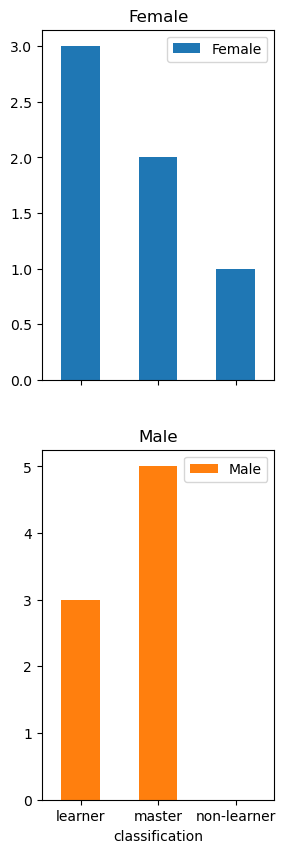

In [101]:
user_nota_classification_gender.plot.bar(subplots=True, figsize=(3, 10), rot=0)

# Relação de tempo entre perguntas

In [102]:
a_questions_df["averageSecondsBwQuestions"] = a_questions_df.groupby(['user', 'level', 'lagunasPhase'])['lastUpdated'].diff().dt.seconds


### Relação de tempo entre perguntas por nível e fase (prática/domínio)

In [103]:
a_questions_df_average_time_level = a_questions_df.groupby(['user', 'level', 'lagunasPhase'])["averageSecondsBwQuestions"].mean().reset_index()
a_questions_df_average_time_level.head(6)

,user,level,lagunasPhase,averageSecondsBwQuestions
0,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,1,domain,10.444444
1,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,1,practice,23.333333
2,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,2,domain,11.666667
3,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,2,practice,19.000000
4,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,3,domain,16.166667
5,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,3,practice,27.285714


lagunasPhase,domain,practice
level,,
1,15.213868,48.517335
2,10.535354,31.333333
3,12.038869,18.221205


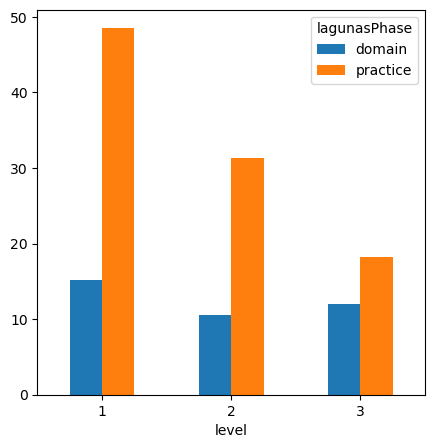

In [104]:
a_questions_df_average_time_level_general = pd.pivot_table(a_questions_df_average_time_level, index = "level", columns="lagunasPhase", values="averageSecondsBwQuestions", aggfunc="mean")
a_questions_df_average_time_level_general.plot.bar(figsize=(5, 5), rot=0)
a_questions_df_average_time_level_general


### Média de tempo entre perguntas por fase (prática/domínio)

In [105]:
a_questions_df_average_time = a_questions_df_average_time_level.groupby(['user', 'lagunasPhase'])["averageSecondsBwQuestions"].mean().reset_index()
a_questions_df_average_time.head(3)

,user,lagunasPhase,averageSecondsBwQuestions
0,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,domain,12.759259
1,1SMOS0VF6uZ0VeLrmL8CS5mOLnw2,practice,23.206349
2,2oh7qd25jNSrFcLrxGlVtAl5hvk1,domain,27.998051


<Axes: xlabel='lagunasPhase'>

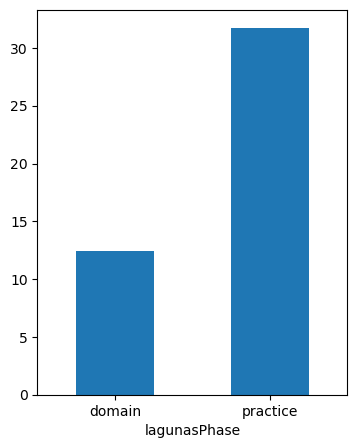

In [106]:
a_questions_df_average_time_general = a_questions_df_average_time.groupby("lagunasPhase")["averageSecondsBwQuestions"].mean()
a_questions_df_average_time_general.plot.bar(figsize=(4, 5), rot=0)
